In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_excel("data1-telematics_syn_orignal data.xlsx", index_col=0)

# Select relevant features for grouping and target variables
features_to_keep = [
    'Insured.age', 'Credit.score', 'Annual.miles.drive', 
    'Car.age', 'Years.noclaims', 'NB_Claim', 'AMT_Claim'
]
df_selected = df[features_to_keep].copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')
df_selected.loc[:, df_selected.columns] = imputer.fit_transform(df_selected[df_selected.columns])

# Handle negative car age by replacing with 0
df_selected['Car.age'] = df_selected['Car.age'].apply(lambda x: max(x, 0))

# Group Binning
age_bin_list = [16, 25, 40, 60, df_selected['Insured.age'].max()]
age_bin_labels = ['16-25', '26-40', '41-60', '61+']
df_selected['age_group'] = pd.cut(df_selected['Insured.age'], bins=age_bin_list, labels=age_bin_labels, include_lowest=True)

# Define Credit Score Groups
credit_score_bins = [422, 600, 700, 800, 900]
credit_score_labels = ['Poor', 'Fair', 'Good', 'Excellent']
df_selected['credit_score_group'] = pd.cut(df_selected['Credit.score'], bins=credit_score_bins, labels=credit_score_labels, include_lowest=True)

# Update Annual mileage groups with the new buckets
annual_miles_bins = [0, 5000, 10000, 15000, 20000, 25000, df_selected['Annual.miles.drive'].max()]
annual_miles_labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k+']
df_selected['annual_miles_group'] = pd.cut(df_selected['Annual.miles.drive'], bins=annual_miles_bins, labels=annual_miles_labels, include_lowest=True)

# Define car age groups - max age of 20
car_age_bins = [0, 5, 10, 15, 20]
car_age_labels = ['0-5', '6-10', '11-15', '16-20']
df_selected['car_age_group'] = pd.cut(df_selected['Car.age'], bins=car_age_bins, labels=car_age_labels, include_lowest=True)

# Years no claims groups
years_noclaims_bins = [0, 10, 20, 30, 40, 50, df_selected['Years.noclaims'].max()]
years_noclaims_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '50+']
df_selected['years_noclaims_group'] = pd.cut(df_selected['Years.noclaims'], bins=years_noclaims_bins, labels=years_noclaims_labels, include_lowest=True)

# Drop the original numeric columns
df_final_prepared = df_selected.drop(columns=['Insured.age', 'Credit.score', 'Annual.miles.drive', 'Car.age', 'Years.noclaims'])

# Save the prepared data
df_final_prepared.to_csv('final_prepared_data.csv', index=False)


# CHECK FOR NAN VALUES

In [2]:
# Load the prepared dataset from previous preprocessing step
df_final_prepared = pd.read_csv('final_prepared_data_relative.csv')

# Check for NaN values across the entire DataFrame
nan_values = df_final_prepared.isnull().sum()

# Check for Inf values only in numeric columns
numeric_columns = df_final_prepared.select_dtypes(include=[np.number])
inf_values = numeric_columns.apply(lambda x: np.isinf(x).sum())

# Display the results
print("NaN values in each column:\n", nan_values)
print("\nInf values in numeric columns:\n", inf_values)


NaN values in each column:
 NB_Claim                0
AMT_Claim               0
age_group               0
credit_score_group      0
annual_miles_group      0
car_age_group           0
years_noclaims_group    0
relative_frequency      0
dtype: int64

Inf values in numeric columns:
 NB_Claim              0
AMT_Claim             0
relative_frequency    0
dtype: int64


# MODEL TRAINING

## GAM

In [3]:
from pygam import PoissonGAM, LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def train_and_predict_gam_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    # Encode the group column
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    # Calculate the target relative frequency and average severity
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')
    X = df_group[[group_column]].values
    y_claims = df_group['target_relative_frequency'].values

    # Perform grid search to find the best lambda for the Poisson GAM
    gam_freq = PoissonGAM(s(0, n_splines=5, lam=0.6))
    lam_range = {'lam': [0.1, 0.3, 0.6, 1.0, 3.0]}
    grid_search = GridSearchCV(gam_freq, lam_range, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(X, y_claims)

    # Fit the GAM model with the best lambda
    best_gam_freq = grid_search.best_estimator_
    df_group['predicted_claims'] = best_gam_freq.predict(X)


    frequency_rmse = np.sqrt(np.mean((df_group['target_relative_frequency'] - df_group['predicted_claims'])**2))
    print(f"Frequency RMSE for group '{group_column}': {frequency_rmse}")
    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()

    if not df_non_zero_claims.empty:
        # Prepare features and targets for claim severity
        X_sev = df_non_zero_claims[[group_column]].values
        y_sev = df_non_zero_claims['target_average_severity'].values
        gam_sev = LinearGAM(s(0, n_splines=5, lam=0.6)).fit(X_sev, y_sev)
        df_non_zero_claims['predicted_severity'] = gam_sev.predict(X_sev)

        severity_rmse = np.sqrt(np.mean((df_non_zero_claims['target_average_severity'] - df_non_zero_claims['predicted_severity'])**2))
        print(f"Severity RMSE for group '{group_column}': {severity_rmse}")
    else:
        df_non_zero_claims['predicted_severity'] = None
        severity_rmse = None
        print(f"No severity RMSE for group '{group_column}' as there are no non-zero claims.")

    # Aggregate the results for frequency and severity predictions
    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_average_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    # Add model and group information to the results for use in explaining the results
    results['model'] = 'gam'
    results['group'] = group_column
    results = results[['model', 'group', group_column, 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')

groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_gam_group(df, group))


final_results = pd.concat(results_list, axis=0)
final_results.to_csv('gam_group_prediction_results.csv', index=False)
print("Results saved to 'gam_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Frequency RMSE for group 'age_group': 0.1264998391940196
Severity RMSE for group 'age_group': 3.1814337452177703
Training and predicting for group 'credit_score_group'
Frequency RMSE for group 'credit_score_group': 0.10803349298735476
Severity RMSE for group 'credit_score_group': 18.311449248596055
Training and predicting for group 'annual_miles_group'
Frequency RMSE for group 'annual_miles_group': 0.15893489161858362
Severity RMSE for group 'annual_miles_group': 15.506382262403438
Training and predicting for group 'car_age_group'
Frequency RMSE for group 'car_age_group': 0.2237468893359843
Severity RMSE for group 'car_age_group': 0.6472593227555119
Training and predicting for group 'years_noclaims_group'
Frequency RMSE for group 'years_noclaims_group': 0.06320986194706751
Severity RMSE for group 'years_noclaims_group': 12.533345967430378
Results saved to 'gam_group_prediction_results.csv'


## XGBOOST

In [23]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

xgb_models = {}
def train_and_predict_xgboost_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')

    X = df_group[[group_column]]
    y_claims = df_group['target_relative_frequency']

    # Use KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model_claims = xgb.XGBRegressor(
        objective='reg:squarederror',
        verbosity=1,
        max_depth=3,
        learning_rate=0.01,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0
    )
    
    # Perform cross-validation
    scores = cross_val_score(model_claims, X, y_claims, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-Validation RMSE for {group_column}: {np.sqrt(-scores.mean()):.4f}")

    # Fit the model and predict the claims
    model_claims.fit(X, y_claims)
    df_group['predicted_claims'] = model_claims.predict(X)
    xgb_models[group_column] = model_claims
    model_claims.save_model(f"{group_column}_xgb_model.json")

    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        y_sev = df_non_zero_claims['target_average_severity']

        model_sev = xgb.XGBRegressor(
            objective='reg:squarederror',
            verbosity=1,
            max_depth=3,
            learning_rate=0.01,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0
        )
        
        # Cross-validation for severity model
        scores_sev = cross_val_score(model_sev, X.loc[df_non_zero_claims.index], y_sev, cv=kf, scoring='neg_mean_squared_error')
        print(f"Cross-Validation RMSE for Severity {group_column}: {np.sqrt(-scores_sev.mean()):.4f}")
        
        model_sev.fit(X.loc[df_non_zero_claims.index], y_sev)
        df_non_zero_claims['predicted_severity'] = model_sev.predict(X.loc[df_non_zero_claims.index])
        xgb_models[f"{group_column}_severity"] = model_sev
        model_sev.save_model(f"{group_column}_xgb_severity_model.json")
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_average_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'xgboost'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_xgboost_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('xgboost_group_prediction_results.csv', index=False)
print("Results saved to 'xgboost_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Cross-Validation RMSE for age_group: 0.0009
Cross-Validation RMSE for Severity age_group: 0.4192
Training and predicting for group 'credit_score_group'
Cross-Validation RMSE for credit_score_group: 0.0008
Cross-Validation RMSE for Severity credit_score_group: 0.7369
Training and predicting for group 'annual_miles_group'
Cross-Validation RMSE for annual_miles_group: 0.0012
Cross-Validation RMSE for Severity annual_miles_group: 0.3048
Training and predicting for group 'car_age_group'
Cross-Validation RMSE for car_age_group: 0.0015
Cross-Validation RMSE for Severity car_age_group: 0.2924
Training and predicting for group 'years_noclaims_group'
Cross-Validation RMSE for years_noclaims_group: 0.0005
Cross-Validation RMSE for Severity years_noclaims_group: 0.5251
Results saved to 'xgboost_group_prediction_results.csv'


## LIGHTGBM

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder


lgb_models = {}
def train_and_predict_lightgbm_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')
    X = df_group[[group_column]]
    y_claims = df_group['target_relative_frequency']

    # Parameters for the LightGBM model
    params_claims = {
        'objective': 'regression',
        'metric': 'l2',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': 5,
        'n_estimators': 500,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.5,
        'reg_lambda': 1.0,
        'verbosity': -1
    }

    # KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model_claims = lgb.LGBMRegressor(**params_claims)
    scores = cross_val_score(model_claims, X, y_claims, cv=kf, scoring='neg_mean_squared_error')
    print(f"Cross-Validation RMSE for {group_column}: {np.sqrt(-scores.mean()):.4f}")
    
    # Fit the model and predict the claims
    model_claims.fit(X, y_claims)
    df_group['predicted_claims'] = model_claims.predict(X)
    lgb_models[group_column] = model_claims
    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        y_sev = df_non_zero_claims['target_average_severity']
        
        # Train the severity model
        model_sev = lgb.LGBMRegressor(**params_claims)
        scores_sev = cross_val_score(model_sev, X.loc[df_non_zero_claims.index], y_sev, cv=kf, scoring='neg_mean_squared_error')
        print(f"Cross-Validation RMSE for Severity {group_column}: {np.sqrt(-scores_sev.mean()):.4f}")        
        model_sev.fit(X.loc[df_non_zero_claims.index], y_sev)
        df_non_zero_claims['predicted_severity'] = model_sev.predict(X.loc[df_non_zero_claims.index])
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_average_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'lightgbm'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)
    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_lightgbm_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('lightgbm_group_prediction_results.csv', index=False)
print("Results saved to 'lightgbm_group_prediction_results.csv'")


Training and predicting for group 'age_group'
Cross-Validation RMSE for age_group: 0.0009
Cross-Validation RMSE for Severity age_group: 0.4176
Training and predicting for group 'credit_score_group'
Cross-Validation RMSE for credit_score_group: 0.0007
Cross-Validation RMSE for Severity credit_score_group: 0.7351
Training and predicting for group 'annual_miles_group'
Cross-Validation RMSE for annual_miles_group: 0.0011
Cross-Validation RMSE for Severity annual_miles_group: 3.8670
Training and predicting for group 'car_age_group'
Cross-Validation RMSE for car_age_group: 0.0015
Cross-Validation RMSE for Severity car_age_group: 1.0280
Training and predicting for group 'years_noclaims_group'
Cross-Validation RMSE for years_noclaims_group: 0.0004
Cross-Validation RMSE for Severity years_noclaims_group: 0.4973
Results saved to 'lightgbm_group_prediction_results.csv'


## FFNN

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

def train_and_predict_ffnn_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])    
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')

    # Log transform the severity target
    df_group['log_target_average_severity'] = np.log1p(df_group['target_average_severity'])
    X = df_group[[group_column]].values
    y_claims = df_group['target_relative_frequency'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train_claims, X_val_claims, y_train_claims, y_val_claims = train_test_split(X_scaled, y_claims, test_size=0.2, random_state=42)
    # Ensure that the shapes are correct
    print(f"X_train_claims shape: {X_train_claims.shape}, y_train_claims shape: {y_train_claims.shape}")
    
    # Build the FFNN model for claim frequency with regularization
    model_claims = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_claims.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model_claims.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_claims.fit(X_train_claims, y_train_claims, epochs=100, batch_size=32, validation_data=(X_val_claims, y_val_claims), callbacks=[early_stopping], verbose=0)
    df_group['predicted_claims'] = model_claims.predict(X_scaled).flatten()

    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()
    if not df_non_zero_claims.empty:
        X_sev = df_non_zero_claims[[group_column]].values
        y_sev = df_non_zero_claims['log_target_average_severity'].values
        X_sev_scaled = scaler.transform(X_sev)
        X_train_sev, X_val_sev, y_train_sev, y_val_sev = train_test_split(X_sev_scaled, y_sev, test_size=0.2, random_state=42)
        
        # Ensure that the shapes are correct
        print(f"X_train_sev shape: {X_train_sev.shape}, y_train_sev shape: {y_train_sev.shape}")
        # Build the FFNN model for claim severity with regularization
        model_sev = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_sev.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='linear')
        ])
        model_sev.compile(optimizer='adam', loss='mse')
        model_sev.fit(X_train_sev, y_train_sev, epochs=100, batch_size=32, validation_data=(X_val_sev, y_val_sev), callbacks=[early_stopping], verbose=0)
        df_non_zero_claims['predicted_log_severity'] = model_sev.predict(X_sev_scaled).flatten()
        df_non_zero_claims['predicted_severity'] = np.expm1(df_non_zero_claims['predicted_log_severity'])
    else:
        df_non_zero_claims['predicted_severity'] = None

    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_average_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    results['model'] = 'ffnn'
    results['group'] = group_column
    results.rename(columns={group_column: 'level'}, inplace=True)
    return results[['model', 'group', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
results_list = []
ffnn_models = {}
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results_list.append(train_and_predict_ffnn_group(df, group))

final_results = pd.concat(results_list, axis=0)
final_results.to_csv('ffnn_group_prediction_results.csv', index=False)
print("Results saved to 'ffnn_group_prediction_results.csv'")


Training and predicting for group 'age_group'
X_train_claims shape: (80000, 1), y_train_claims shape: (80000,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
X_train_sev shape: (3417, 1), y_train_sev shape: (3417,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
Training and predicting for group 'credit_score_group'
X_train_claims shape: (80000, 1), y_train_claims shape: (80000,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step
X_train_sev shape: (3417, 1), y_train_sev shape: (3417,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
Training and predicting for group 'annual_miles_group'
X_train_claims shape: (80000, 1), y_train_claims shape: (80000,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
X_train_sev shape: (3417, 1), y_train_sev shape: (3417,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
Training and predicting for group 'car_age_group'
X_train_claims shape: (80000, 1), y_train_claims shape: (80000,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
X_train_sev shape: (3417, 1), y_train_sev shape: (3417,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
Training and predicting for group 'years_noclaims_group'
X_train_claims shape: (80000, 1), y_train_claims shape: (80000,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
X_train_sev shape: (3417, 1), y_train_sev shape: (3417,)


/Users/joco/anaconda3/envs/graphmining/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
Results saved to 'ffnn_group_prediction_results.csv'


# Results comparison

## Combine data points across models

In [7]:
# Load the results for each model
models = ['gam', 'xgboost', 'lightgbm', 'ffnn']
results = []
for model in models:
    file_name = f'{model}_group_prediction_results.csv'
    df = pd.read_csv(file_name)
    df['model'] = model
    results.append(df)

# Combine the results from all models
combined_results = pd.concat(results, axis=0)
def map_levels(df):
    mapping_dict = {
        'age_group': {0: '16-25', 1: '26-40', 2: '41-60', 3: '61+'},
        'credit_score_group': {0: 'Poor', 1: 'Fair', 2: 'Good', 3: 'Excellent'},
        'annual_miles_group': {0: '0-5000', 1: '5000-10000', 2: '10000-15000', 3: '15000-20000', 4: '20000-25000', 5: '25000+'},
        'car_age_group': {0: '0-5', 1: '6-10', 2: '11-15', 3: '16-20'},
        'years_noclaims_group': {0: '0-10', 1: '11-20', 2: '21-30', 3: '31-40', 4: '41-50', 5: '50+'}
    }
    for group, mapping in mapping_dict.items():
        df.loc[df['group'] == group, 'level'] = df.loc[df['group'] == group, 'level'].map(mapping)
    return df

# Map the levels to the original values
combined_results = map_levels(combined_results)
# Convert the frequency values to percentages
combined_results['actual_frequency'] *= 100
combined_results['predicted_frequency'] *= 100

combined_results.to_csv('combined_model_comparison_results.csv', index=False)
print("Combined results saved to 'combined_model_comparison_results.csv'")


Combined results saved to 'combined_model_comparison_results.csv'


/var/folders/9t/ttq9f0sd08567xh5d9b7lmvw0000gn/T/ipykernel_27805/702139585.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['16-25' '26-40' '41-60' '61+' '16-25' '26-40' '41-60' '61+' '16-25'
 '26-40' '41-60' '61+' '16-25' '26-40' '41-60' '61+']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['group'] == group, 'level'] = df.loc[df['group'] == group, 'level'].map(mapping)


## Visualize Predictions vs Actual

In [8]:
# Load the combined results
combined_results = pd.read_csv('combined_model_comparison_results.csv')

# Display the first few rows of the combined results
print(combined_results.head())


  model               group  level  actual_frequency  predicted_frequency  \
0   gam           age_group  16-25          6.542056            31.980607   
1   gam           age_group  26-40         28.437917            31.980607   
2   gam           age_group  41-60         45.950156            31.980607   
3   gam           age_group    61+         19.069871            31.980607   
4   gam  credit_score_group   Poor         44.926569            38.039239   

   actual_severity  predicted_severity  
0       311.547815          305.707721  
1       191.658714          195.612270  
2       153.847609          151.412097  
3        54.120658           56.059460  
4        70.208243           74.264255  


Processing group: age_group


<Figure size 1200x800 with 0 Axes>

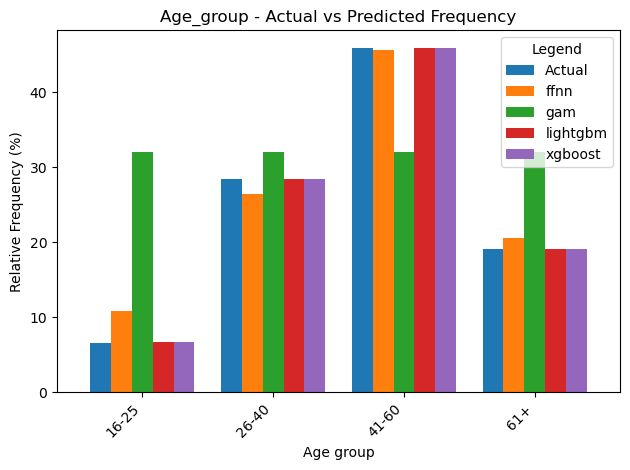

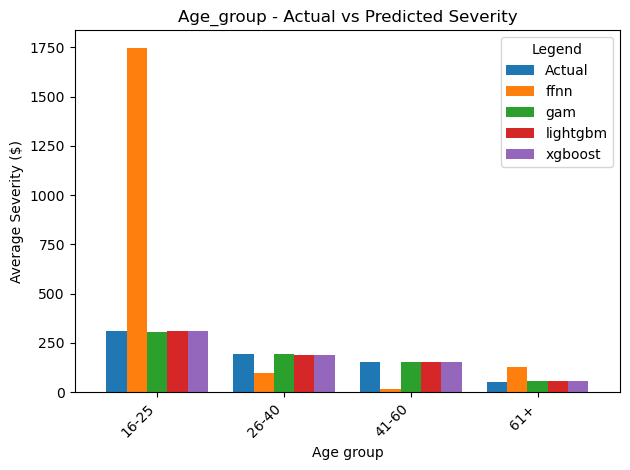

Summary table saved to age_group_summary_results.csv
Summary table for Age_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     gam 16-25          6.542056            31.980607       311.547815          305.707721
     gam 26-40         28.437917            31.980607       191.658714          195.612270
     gam 41-60         45.950156            31.980607       153.847609          151.412097
     gam   61+         19.069871            31.980607        54.120658           56.059460
 xgboost 16-25          6.542056             6.726181       311.547815          310.499760
 xgboost 26-40         28.437917            28.463832       191.658714          191.422260
 xgboost 41-60         45.950156            45.856850       153.847609          153.861630
 xgboost   61+         19.069871            19.156711        54.120658           54.795555
lightgbm 16-25          6.542056             6.722761       311.547815          310.504867
lightgb

<Figure size 1200x800 with 0 Axes>

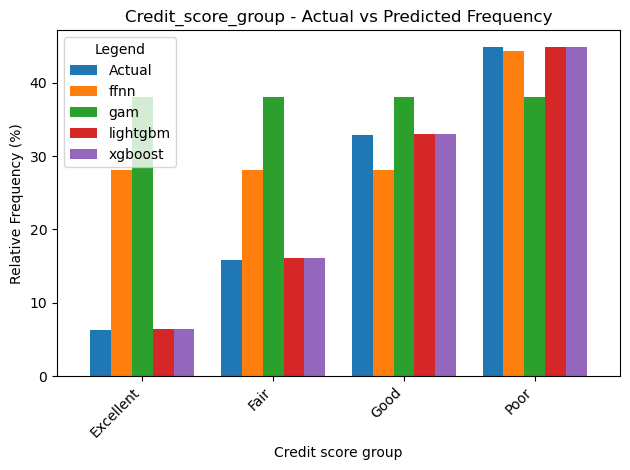

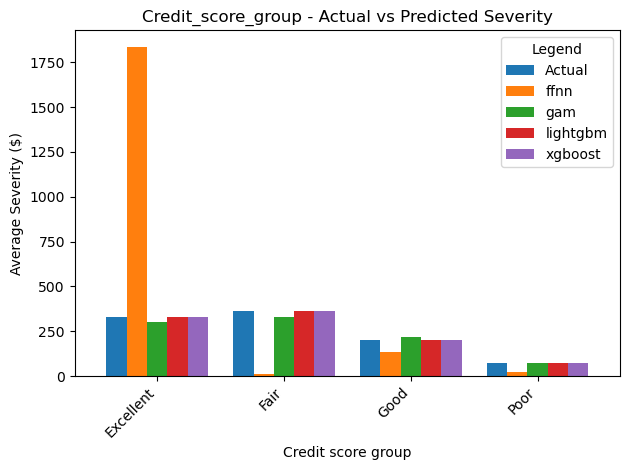

Summary table saved to credit_score_group_summary_results.csv
Summary table for Credit_score_group:

   model     level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     gam      Poor         44.926569            38.039239        70.208243           74.264255
     gam      Fair         15.887850            38.039239       364.718970          329.458791
     gam      Good         32.932799            38.039239       201.731027          218.040017
     gam Excellent          6.252781            38.039239       329.085773          300.777819
 xgboost      Poor         44.926569            44.880334        70.208243           70.895410
 xgboost      Fair         15.887850            16.040473       364.718970          363.455720
 xgboost      Good         32.932799            32.968926       201.731027          201.550230
 xgboost Excellent          6.252781             6.479083       329.085773          328.042330
lightgbm      Poor         44.926569        

<Figure size 1200x800 with 0 Axes>

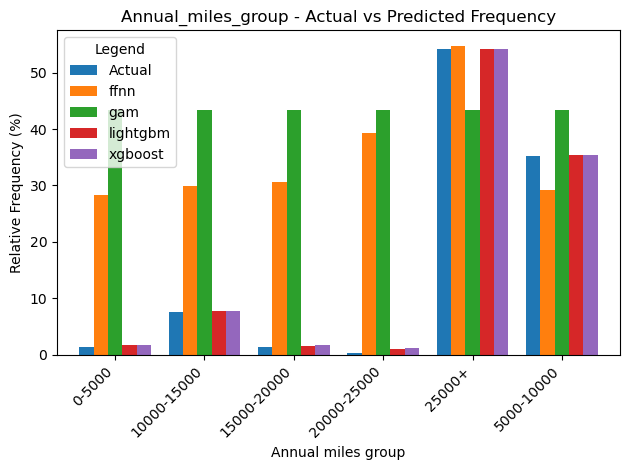

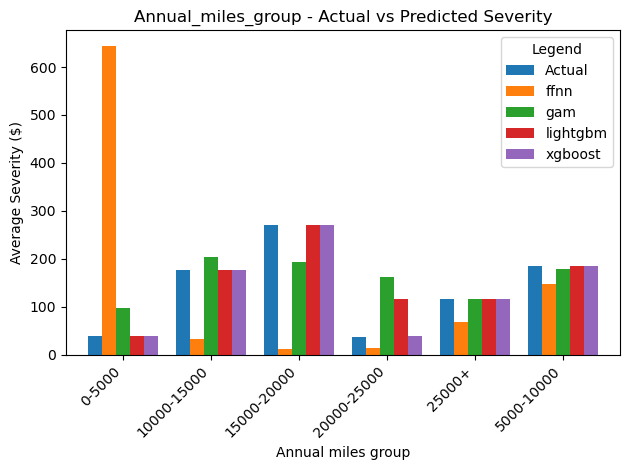

Summary table saved to annual_miles_group_summary_results.csv
Summary table for Annual_miles_group:

   model       level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     gam      0-5000          1.401869            43.351605        37.960867           98.287147
     gam  5000-10000         35.291500            43.351605       185.319570          178.985259
     gam 10000-15000          7.521139            43.351605       176.639999          204.304888
     gam 15000-20000          1.268358            43.351605       270.974533          194.098310
     gam 20000-25000          0.244771            43.351605        36.557350          162.189315
     gam      25000+         54.272363            43.351605       116.413317          116.373206
 xgboost      0-5000          1.401869             1.692365        37.960867           38.756767
 xgboost  5000-10000         35.291500            35.346570       185.319570          184.985440
 xgboost 10000-15000      

<Figure size 1200x800 with 0 Axes>

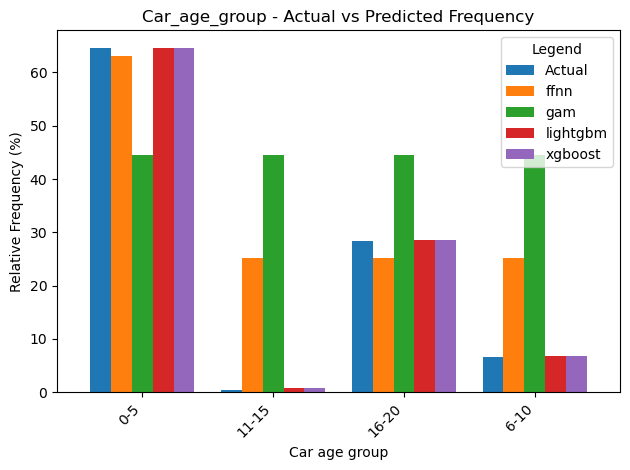

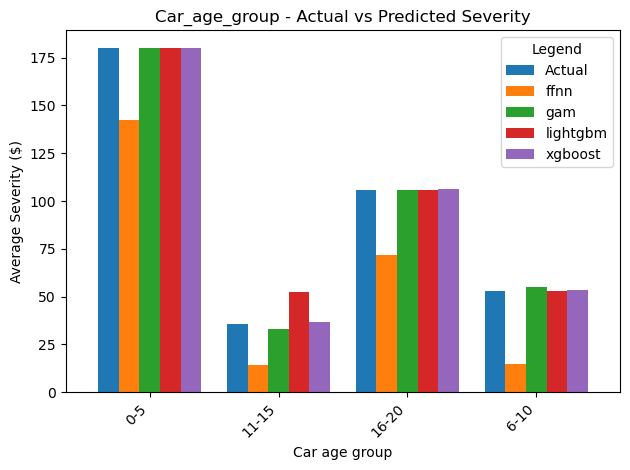

Summary table saved to car_age_group_summary_results.csv
Summary table for Car_age_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     gam   0-5         64.663996            44.469329       180.273287          180.116011
     gam  6-10          6.542056            44.469329        52.754878           55.133492
     gam 11-15          0.333778            44.469329        35.668826           33.175171
     gam 16-20         28.460169            44.469329       105.770142          105.606101
 xgboost   0-5         64.663996            64.530100       180.273287          180.075230
 xgboost  6-10          6.542056             6.782822        52.754878           53.404015
 xgboost 11-15          0.333778             0.793758        35.668826           36.966923
 xgboost 16-20         28.460169            28.567195       105.770142          106.064310
lightgbm   0-5         64.663996            64.530348       180.273287          180.075334

<Figure size 1200x800 with 0 Axes>

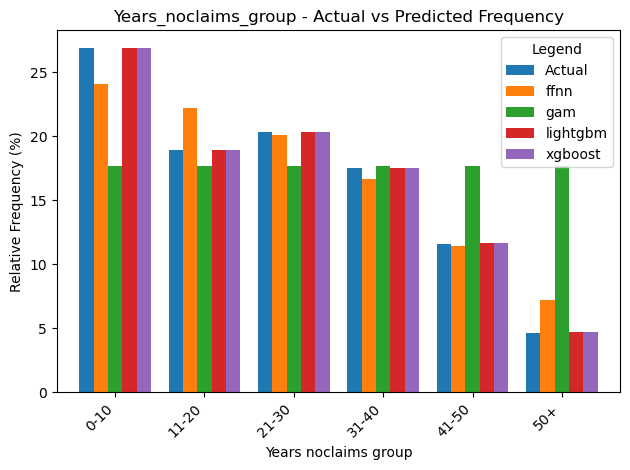

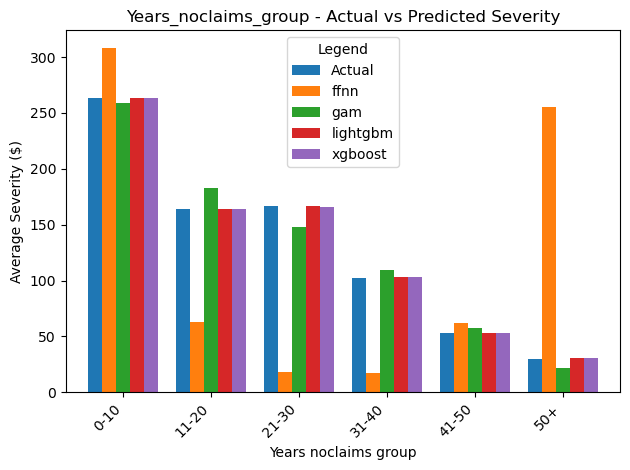

Summary table saved to years_noclaims_group_summary_results.csv
Summary table for Years_noclaims_group:

   model level  actual_frequency  predicted_frequency  actual_severity  predicted_severity
     gam  0-10         26.947040            17.657243       263.650376          259.056816
     gam 11-20         18.914108            17.657243       163.822690          182.848138
     gam 21-30         20.360481            17.657243       166.453456          148.074681
     gam 31-40         17.534490            17.657243       102.667124          109.221979
     gam 41-50         11.593235            17.657243        52.757711           57.681751
     gam   50+          4.650645            17.657243        29.829242           21.751895
 xgboost  0-10         26.947040            26.882404       263.650376          262.970580
 xgboost 11-20         18.914108            18.929967       163.822690          164.002060
 xgboost 21-30         20.360481            20.310828       166.453456      

In [9]:
import matplotlib.pyplot as plt

# Load the combined results
combined_results = pd.read_csv('combined_model_comparison_results.csv')
def plot_grouped_bar_chart(group_name, y_label_freq, y_label_sev, title_suffix, filename_suffix):
    plt.figure(figsize=(12, 8))
    
    # Filter data for the group
    plot_data = combined_results[combined_results['group'] == group_name].copy()
    
    # Get unique levels and models
    levels = plot_data['level'].unique()
    models = plot_data['model'].unique()
    plot_rows = []
    for level in levels:
        actual_freq = plot_data.loc[plot_data['level'] == level, 'actual_frequency'].values[0]
        actual_sev = plot_data.loc[plot_data['level'] == level, 'actual_severity'].values[0]
        plot_rows.append({'Level': level, 'Type': 'Actual', 'Value': actual_freq})
        plot_rows.append({'Level': level, 'Type': 'Actual', 'Value': actual_sev})
        
        for model in models:
            predicted_freq = plot_data.loc[(plot_data['level'] == level) & (plot_data['model'] == model), 'predicted_frequency'].values[0]
            predicted_sev = plot_data.loc[(plot_data['level'] == level) & (plot_data['model'] == model), 'predicted_severity'].values[0]
            plot_rows.append({'Level': level, 'Type': model, 'Value': predicted_freq})
            plot_rows.append({'Level': level, 'Type': model, 'Value': predicted_sev})
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_rows)
    freq_df = plot_df.iloc[::2]
    sev_df = plot_df.iloc[1::2]    
    pivot_freq = freq_df.pivot(index='Level', columns='Type', values='Value')
    pivot_freq.plot(kind='bar', width=0.8)

    # Plot the grouped bar chart for Frequency
    plt.title(f'{group_name.capitalize()} - {title_suffix} Frequency')
    plt.ylabel(y_label_freq)
    plt.xlabel(group_name.replace('_', ' ').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.show()

    # Plot the grouped bar chart for Severity
    pivot_sev = sev_df.pivot(index='Level', columns='Type', values='Value')
    pivot_sev.plot(kind='bar', width=0.8)
    plt.title(f'{group_name.capitalize()} - {title_suffix} Severity')
    plt.ylabel(y_label_sev)
    plt.xlabel(group_name.replace('_', ' ').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.show()


    summary_table = plot_data[['model', 'level', 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    summary_csv_filename = f'{group_name}_summary_results.csv'
    summary_table.to_csv(summary_csv_filename, index=False)
    print(f"Summary table saved to {summary_csv_filename}")

    return summary_table

# Define the groups for plotting
groups = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
for group in groups:
    print(f"Processing group: {group}")
    summary_table = plot_grouped_bar_chart(
        group_name=group,
        y_label_freq='Relative Frequency (%)',
        y_label_sev='Average Severity ($)',
        title_suffix='Actual vs Predicted',
        filename_suffix='comparison'
    )    
    print(f"Summary table for {group.capitalize()}:\n")
    print(summary_table.to_string(index=False))
    print("\n" + "-" * 80 + "\n")
print("Visualizations displayed and saved as PNG files, and summary tables saved as CSV files.")


## CALCULATE PERFORMACE METRICS

In [27]:
def compute_accuracy_metrics_by_level(summary_csv_filename):
    """Compute RMSE and MAE for each level within the group."""
    print(f"Processing file: {summary_csv_filename}")
    summary_df = pd.read_csv(summary_csv_filename)
    
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')

    results = []
    for _, row in summary_df.iterrows():
        frequency_rmse = np.sqrt((row['actual_frequency'] - row['predicted_frequency'])**2)
        frequency_mae = abs(row['actual_frequency'] - row['predicted_frequency'])
        severity_rmse = np.sqrt((row['actual_severity'] - row['predicted_severity'])**2)
        severity_mae = abs(row['actual_severity'] - row['predicted_severity'])

        results.append({
            'model_name': row['model'],
            'group': row['group'],
            'level': row['level'],
            'frequency_rmse': frequency_rmse,
            'frequency_mae': frequency_mae,
            'severity_rmse': severity_rmse,
            'severity_mae': severity_mae
        })
    
    accuracy_df = pd.DataFrame(results)
    accuracy_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_accuracy_results.csv')
    accuracy_df.to_csv(accuracy_csv_filename, index=False)
    print(f"Accuracy metrics by level saved to {accuracy_csv_filename}")
    
    return accuracy_df

def compute_accuracy_metrics_all_levels(summary_csv_filename):
    """Compute and save RMSE and MAE for all levels across each group, for all models."""
    print(f"Processing overall metrics for file: {summary_csv_filename}")
    summary_df = pd.read_csv(summary_csv_filename)
    
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')

    models = summary_df['model'].unique()

    all_results = []

    for model in models:
        model_df = summary_df[summary_df['model'] == model]

        freq_metrics_all_levels = {
            'rmse': np.sqrt(np.mean((model_df['actual_frequency'] - model_df['predicted_frequency'])**2)),
            'mae': np.mean(abs(model_df['actual_frequency'] - model_df['predicted_frequency']))
        }

        sev_metrics_all_levels = {
            'rmse': np.sqrt(np.mean((model_df['actual_severity'] - model_df['predicted_severity'])**2)),
            'mae': np.mean(abs(model_df['actual_severity'] - model_df['predicted_severity']))
        }

        results = {
            'model_name': model,
            'group': model_df['group'].iloc[0],
            'level': 'all_levels', 
            'frequency_rmse': freq_metrics_all_levels['rmse'],
            'frequency_mae': freq_metrics_all_levels['mae'],
            'severity_rmse': sev_metrics_all_levels['rmse'],
            'severity_mae': sev_metrics_all_levels['mae']
        }

        all_results.append(results)

    accuracy_all_levels_df = pd.DataFrame(all_results)
    accuracy_all_levels_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_all_levels_metrics_accuracy_results.csv')
    accuracy_all_levels_df.to_csv(accuracy_all_levels_csv_filename, index=False)
    print(f"Overall accuracy metrics saved to {accuracy_all_levels_csv_filename}")
    
    return accuracy_all_levels_df

# Define the summary CSV files corresponding to each group
summary_csv_files = [
    'age_group_summary_results.csv',
    'credit_score_group_summary_results.csv',
    'annual_miles_group_summary_results.csv',
    'car_age_group_summary_results.csv',
    'years_noclaims_group_summary_results.csv'
]

# Compute and display accuracy metrics for each level in each group
for summary_csv in summary_csv_files:
    accuracy_df = compute_accuracy_metrics_by_level(summary_csv)
    print(f"\nAccuracy metrics by level for {summary_csv.replace('_summary_results.csv', '').replace('_', ' ').capitalize()}:\n")
    print(accuracy_df[['model_name', 'group', 'level', 'frequency_rmse', 'frequency_mae', 'severity_rmse', 'severity_mae']].to_string(index=False))
    print("\n" + "-" * 80 + "\n")

# Compute and save overall accuracy metrics for all levels
for summary_csv in summary_csv_files:
    accuracy_all_levels_df = compute_accuracy_metrics_all_levels(summary_csv)
    print(f"\nOverall accuracy metrics for all levels in {summary_csv.replace('_summary_results.csv', '').replace('_', ' ').capitalize()}:\n")
    print(accuracy_all_levels_df[['model_name', 'group', 'level', 'frequency_rmse', 'frequency_mae', 'severity_rmse', 'severity_mae']].to_string(index=False))
    print("\n" + "-" * 80 + "\n")


Processing file: age_group_summary_results.csv
Accuracy metrics by level saved to age_group_accuracy_results.csv

Accuracy metrics by level for Age group:

model_name     group level  frequency_rmse  frequency_mae  severity_rmse  severity_mae
       gam age group 16-25       25.438551      25.438551       5.840094      5.840094
       gam age group 26-40        3.542690       3.542690       3.953556      3.953556
       gam age group 41-60       13.969548      13.969548       2.435512      2.435512
       gam age group   61+       12.910737      12.910737       1.938803      1.938803
   xgboost age group 16-25        0.184125       0.184125       1.048055      1.048055
   xgboost age group 26-40        0.025915       0.025915       0.236454      0.236454
   xgboost age group 41-60        0.093306       0.093306       0.014021      0.014021
   xgboost age group   61+        0.086840       0.086840       0.674897      0.674897
  lightgbm age group 16-25        0.180705       0.180705    

## BEST OVERALL PERFORMING MODEL

In [33]:
def determine_best_performing_model(accuracy_csv_files, metric='rmse'):
    model_performance = {}    
    for accuracy_csv in accuracy_csv_files:
        accuracy_df = pd.read_csv(accuracy_csv)    
        for model in accuracy_df['model_name'].unique():
            model_df = accuracy_df[accuracy_df['model_name'] == model]            
            
            # Aggregate metrics for the model
            freq_rmse_mean = model_df['frequency_rmse'].mean()
            freq_mae_mean = model_df['frequency_mae'].mean()
            sev_rmse_mean = model_df['severity_rmse'].mean()
            sev_mae_mean = model_df['severity_mae'].mean()            
            if model not in model_performance:
                model_performance[model] = {
                    'frequency_rmse': [],
                    'frequency_mae': [],
                    'severity_rmse': [],
                    'severity_mae': []
                }            
            model_performance[model]['frequency_rmse'].append(freq_rmse_mean)
            model_performance[model]['frequency_mae'].append(freq_mae_mean)
            model_performance[model]['severity_rmse'].append(sev_rmse_mean)
            model_performance[model]['severity_mae'].append(sev_mae_mean)
    
    # Calculate average performance metrics for each model
    avg_performance = {}
    for model, metrics in model_performance.items():
        avg_performance[model] = {
            'avg_frequency_rmse': sum(metrics['frequency_rmse']) / len(metrics['frequency_rmse']),
            'avg_frequency_mae': sum(metrics['frequency_mae']) / len(metrics['frequency_mae']),
            'avg_severity_rmse': sum(metrics['severity_rmse']) / len(metrics['severity_rmse']),
            'avg_severity_mae': sum(metrics['severity_mae']) / len(metrics['severity_mae'])
        }
    
    # Determine the best performing model based on the specified metric
    if metric == 'rmse':
        best_model = min(avg_performance, key=lambda x: avg_performance[x]['avg_frequency_rmse'])
    elif metric == 'mae':
        best_model = min(avg_performance, key=lambda x: avg_performance[x]['avg_frequency_mae'])
    else:
        raise ValueError("Metric must be 'rmse' or 'mae'")
    
    print(f"Best Performing Model based on {metric.upper()}: {best_model}")
    print(f"Average Metrics for {best_model}: {avg_performance[best_model]}")
    return avg_performance, best_model

# Define the accuracy CSV files corresponding to each group
accuracy_csv_files = [
    'age_group_accuracy_results.csv',
    'credit_score_group_accuracy_results.csv',
    'annual_miles_group_accuracy_results.csv',
    'car_age_group_accuracy_results.csv',
    'years_noclaims_group_accuracy_results.csv'
]
avg_performance_rmse, best_model_rmse = determine_best_performing_model(accuracy_csv_files, metric='rmse')

# Determine the best performing model based on MAE
avg_performance_mae, best_model_mae = determine_best_performing_model(accuracy_csv_files, metric='mae')


Best Performing Model based on RMSE: lightgbm
Average Metrics for lightgbm: {'avg_frequency_rmse': 0.15499907719802536, 'avg_frequency_mae': 0.15499907719802536, 'avg_severity_rmse': 3.9575557776111787, 'avg_severity_mae': 3.9575557776111787}
Best Performing Model based on MAE: lightgbm
Average Metrics for lightgbm: {'avg_frequency_rmse': 0.15499907719802536, 'avg_frequency_mae': 0.15499907719802536, 'avg_severity_rmse': 3.9575557776111787, 'avg_severity_mae': 3.9575557776111787}


### All levels

In [30]:
def determine_best_model_all_levels(accuracy_all_levels_csv_files):
    model_performance_mae = {}
    model_performance_rmse = {}    
    for accuracy_csv in accuracy_all_levels_csv_files:
        accuracy_df = pd.read_csv(accuracy_csv)
        for model in accuracy_df['model_name'].unique():
            model_df = accuracy_df[accuracy_df['model_name'] == model]
            
            # Aggregate metrics for the model
            freq_mae = model_df['frequency_mae'].iloc[0]
            sev_mae = model_df['severity_mae'].iloc[0]
            freq_rmse = model_df['frequency_rmse'].iloc[0]
            sev_rmse = model_df['severity_rmse'].iloc[0]
            
            if model not in model_performance_mae:
                model_performance_mae[model] = {
                    'frequency_mae': [],
                    'severity_mae': []
                }
                
            if model not in model_performance_rmse:
                model_performance_rmse[model] = {
                    'frequency_rmse': [],
                    'severity_rmse': []
                }            
            model_performance_mae[model]['frequency_mae'].append(freq_mae)
            model_performance_mae[model]['severity_mae'].append(sev_mae)
            model_performance_rmse[model]['frequency_rmse'].append(freq_rmse)
            model_performance_rmse[model]['severity_rmse'].append(sev_rmse)
    
    # Calculate average performance metrics for each model
    avg_performance_mae = {}
    avg_performance_rmse = {}    
    for model, metrics in model_performance_mae.items():
        avg_performance_mae[model] = {
            'avg_frequency_mae': sum(metrics['frequency_mae']) / len(metrics['frequency_mae']),
            'avg_severity_mae': sum(metrics['severity_mae']) / len(metrics['severity_mae'])
        }
        
    for model, metrics in model_performance_rmse.items():
        avg_performance_rmse[model] = {
            'avg_frequency_rmse': sum(metrics['frequency_rmse']) / len(metrics['frequency_rmse']),
            'avg_severity_rmse': sum(metrics['severity_rmse']) / len(metrics['severity_rmse'])
        }
    
    best_model_mae = min(avg_performance_mae, key=lambda x: avg_performance_mae[x]['avg_frequency_mae'] + avg_performance_mae[x]['avg_severity_mae'])
    best_model_rmse = min(avg_performance_rmse, key=lambda x: avg_performance_rmse[x]['avg_frequency_rmse'] + avg_performance_rmse[x]['avg_severity_rmse'])    
    print(f"Best Performing Model Based on MAE: {best_model_mae}")
    print(f"Average MAE Metrics for {best_model_mae}: {avg_performance_mae[best_model_mae]}")    
    print(f"\nBest Performing Model Based on RMSE: {best_model_rmse}")
    print(f"Average RMSE Metrics for {best_model_rmse}: {avg_performance_rmse[best_model_rmse]}")
    
    return avg_performance_mae, best_model_mae, avg_performance_rmse, best_model_rmse

# Define the accuracy CSV files corresponding to all levels
accuracy_all_levels_csv_files = [
    'age_group_all_levels_metrics_accuracy_results.csv',
    'credit_score_group_all_levels_metrics_accuracy_results.csv',
    'annual_miles_group_all_levels_metrics_accuracy_results.csv',
    'car_age_group_all_levels_metrics_accuracy_results.csv',
    'years_noclaims_group_all_levels_metrics_accuracy_results.csv'
]

# Determine the best performing model based on MAE and RMSE
avg_performance_mae, best_model_mae, avg_performance_rmse, best_model_rmse = determine_best_model_all_levels(accuracy_all_levels_csv_files)


Best Performing Model Based on MAE: xgboost
Average MAE Metrics for xgboost: {'avg_frequency_mae': 0.16206689713915007, 'avg_severity_mae': 0.6151955506849915}

Best Performing Model Based on RMSE: xgboost
Average RMSE Metrics for xgboost: {'avg_frequency_rmse': 0.20076961860553344, 'avg_severity_rmse': 0.7380447114689943}


## MODEL BIAS

In [34]:
def calculate_bias(summary_csv_filename):
    """Calculate the bias for each level within a group."""
    summary_df = pd.read_csv(summary_csv_filename)
    summary_df['frequency_bias'] = summary_df['predicted_frequency'] - summary_df['actual_frequency']
    summary_df['severity_bias'] = summary_df['predicted_severity'] - summary_df['actual_severity']
    
    # Save bias results to a new CSV file
    if 'group' not in summary_df.columns:
        summary_df['group'] = summary_csv_filename.replace('_summary_results.csv', '').replace('_', ' ')
    
    bias_csv_filename = summary_csv_filename.replace('_summary_results.csv', '_bias_results.csv')
    summary_df.to_csv(bias_csv_filename, index=False)
    print(f"Bias metrics saved to {bias_csv_filename}")
    
    return bias_csv_filename


In [35]:
import matplotlib.pyplot as plt

def plot_bias_with_grouped_barplots(bias_csv_filename):
    """Visualize bias for each level within a group using grouped bar plots."""
    bias_df = pd.read_csv(bias_csv_filename)

    # Use 'model' instead of 'model_name'
    if 'model' not in bias_df.columns:
        print("Error: 'model' column not found. Available columns are:", bias_df.columns)
        return

    levels = bias_df['level'].unique()
    models = bias_df['model'].unique()

    # Plot frequency bias using grouped bar plots
    plt.figure(figsize=(12, 8))
    bar_width = 0.2
    index = np.arange(len(levels))
    for i, model in enumerate(models):
        model_data = bias_df[bias_df['model'] == model]
        plt.bar(index + i * bar_width, model_data['frequency_bias'], bar_width, label=f'{model} Frequency Bias')

    plt.title(f"Frequency Bias for {bias_df['group'].iloc[0]}")
    plt.xlabel('Level')
    plt.ylabel('Frequency Bias')
    plt.xticks(index + bar_width * (len(models) - 1) / 2, levels, rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    # Plot severity bias using grouped bar plots
    plt.figure(figsize=(12, 8))    
    for i, model in enumerate(models):
        model_data = bias_df[bias_df['model'] == model]
        plt.bar(index + i * bar_width, model_data['severity_bias'], bar_width, label=f'{model} Severity Bias')

    plt.title(f"Severity Bias for {bias_df['group'].iloc[0]}")
    plt.xlabel('Level')
    plt.ylabel('Severity Bias')
    plt.xticks(index + bar_width * (len(models) - 1) / 2, levels, rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

Bias metrics saved to credit_score_group_bias_results.csv


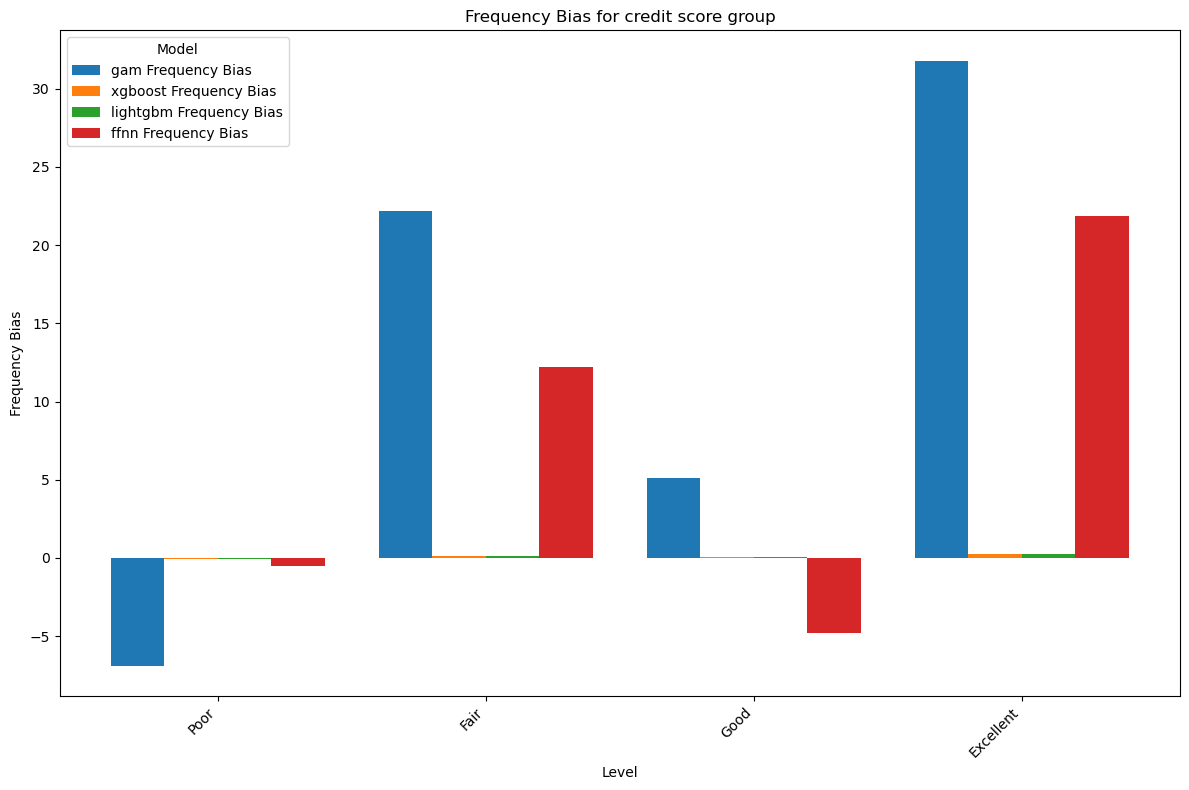

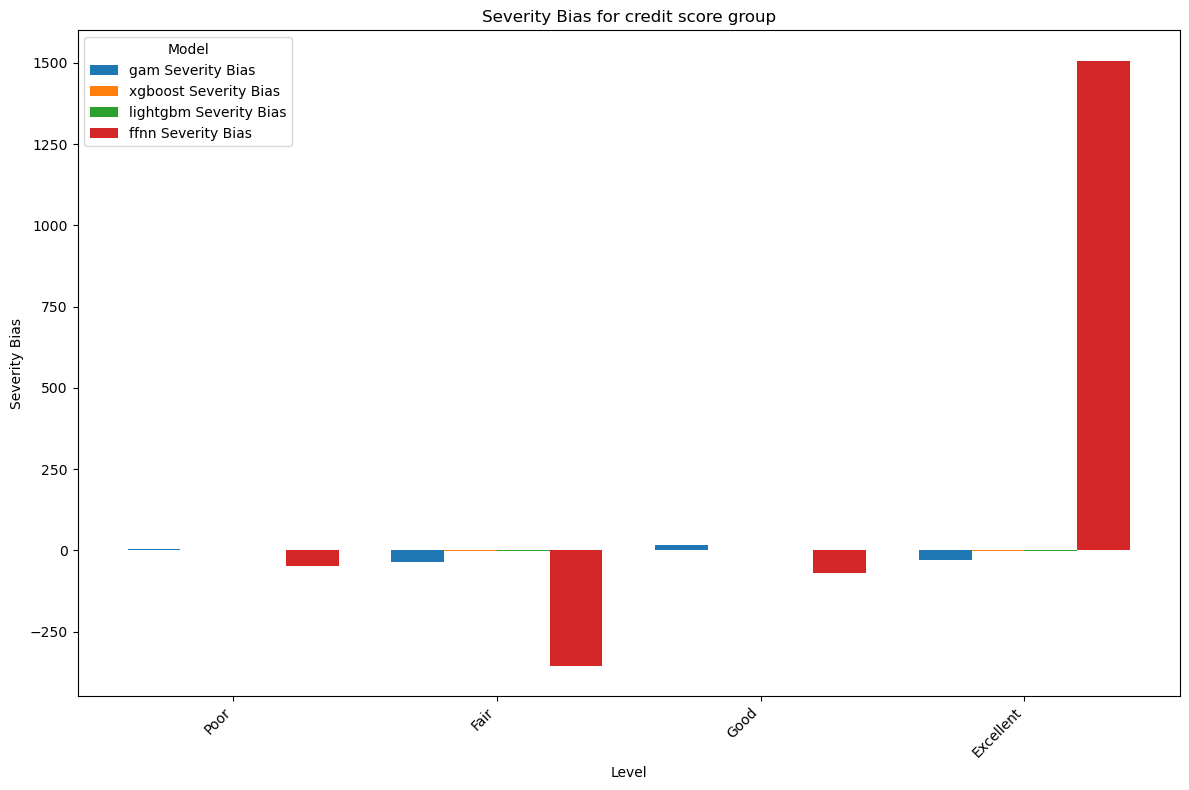

In [36]:
bias_csv_filename = calculate_bias('credit_score_group_summary_results.csv')
plot_bias_with_grouped_barplots(bias_csv_filename)


# FEATURE IMPORTANCE: For best performing model xgboost

SHAP values saved to age_group_shap_values.csv


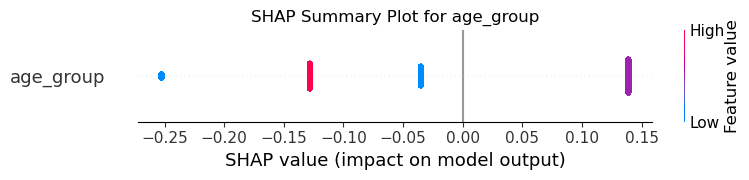

SHAP values saved to credit_score_group_shap_values.csv


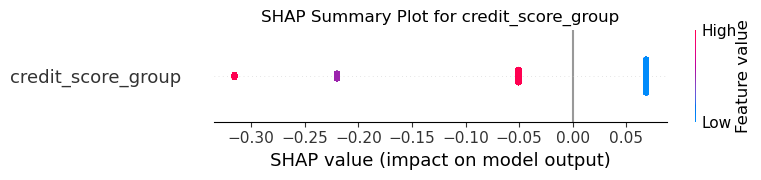

SHAP values saved to annual_miles_group_shap_values.csv


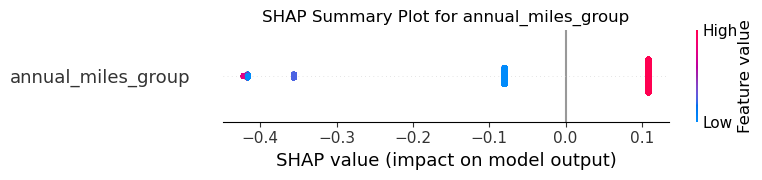

SHAP values saved to car_age_group_shap_values.csv


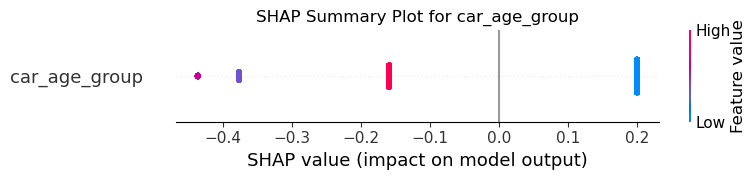

SHAP values saved to years_noclaims_group_shap_values.csv


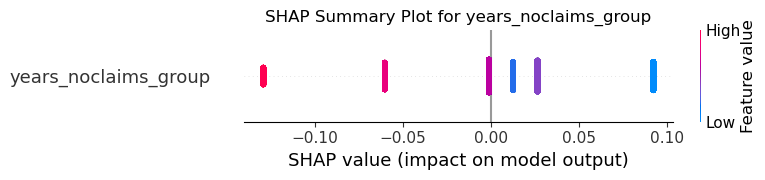

In [24]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load pre-trained models
xgb_models = {}
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
for group in groups_of_interest:
    model = xgb.XGBRegressor()
    model.load_model(f"{group}_xgb_model.json")  # Load the saved model
    xgb_models[group] = model

# Function to calculate SHAP values for a specific group using a saved XGBoost model
def calculate_shap_with_saved_xgb_models(df, group_column, xgb_models):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    # Calculate target relative frequency and average severity
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')

    # Retrieve the features and target variable
    X = df_group[[group_column]]
    # Load the XGBoost model
    model = xgb_models[group_column]
    # Calculate SHAP values using TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Save SHAP values and features to a CSV file
    shap_df = pd.DataFrame(shap_values, columns=[f"SHAP_{group_column}"])
    shap_df[group_column] = X[group_column].values
    output_filename = f"{group_column}_shap_values.csv"
    shap_df.to_csv(output_filename, index=False)
    print(f"SHAP values saved to {output_filename}")

    return shap_values, X, group_column

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')

# Calculate SHAP values for each group and save to CSV
for group in groups_of_interest:
    shap_values, X, group_column = calculate_shap_with_saved_xgb_models(df, group, xgb_models)
    # Plot SHAP summary for each group
    plt.title(f'SHAP Summary Plot for {group_column}')
    shap.summary_plot(shap_values, X, feature_names=[group_column])
    plt.show()


## Summarize the SHAP Analysis Across Groups

### XGBOOST

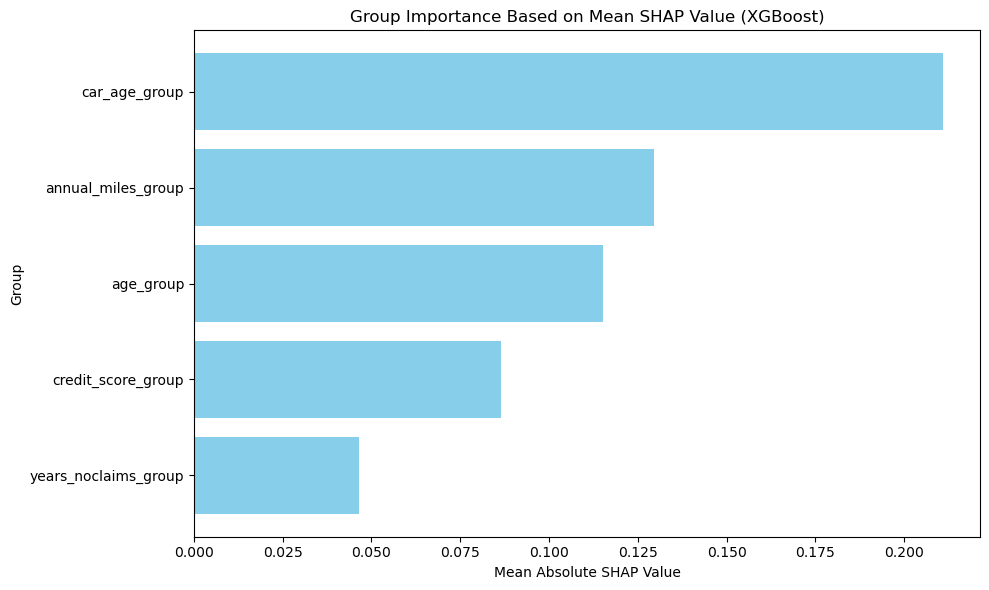

In [26]:
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


def calculate_shap_values_for_group(df, group_column):
    model = xgb_models.get(group_column)
    if model is None:
        print(f"No model found for group '{group_column}'")
        return None, None
    # Prepare the data for SHAP analysis
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    X = df_group[[group_column]]

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    return shap_values, X

# Load the prepared dataset
df = pd.read_csv('final_prepared_data.csv')
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']
shap_summary = pd.DataFrame()

# Calculate SHAP values for each group and aggregate
for group in groups_of_interest:
    shap_values, X = calculate_shap_values_for_group(df, group)
    if shap_values is not None:
        # Aggregate mean absolute SHAP values for the group
        mean_abs_shap = pd.DataFrame({
            'Group': group,
            'Mean SHAP Value': np.abs(shap_values).mean(axis=0)
        })
        shap_summary = pd.concat([shap_summary, mean_abs_shap], axis=0)

# Save the SHAP summary to a CSV file
shap_summary = shap_summary.sort_values(by='Mean SHAP Value', ascending=False)
shap_summary.to_csv('xgb_shap_group_importance_summary.csv', index=False)

# Visualize the Group Importance
plt.figure(figsize=(10, 6))
plt.barh(shap_summary['Group'], shap_summary['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Group')
plt.title('Group Importance Based on Mean SHAP Value (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## FEATURE IMPORTANCE LIGHTGBM

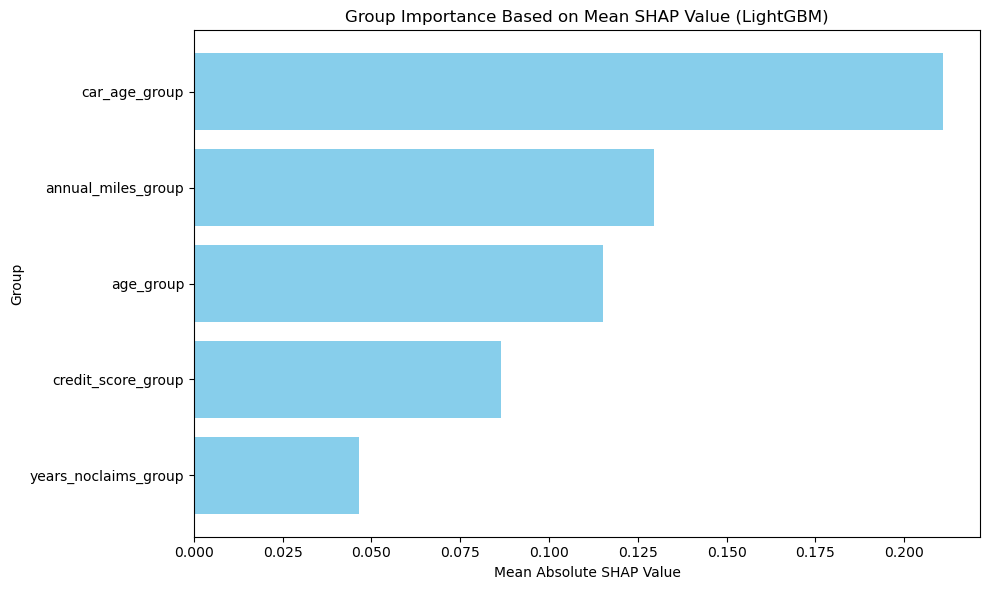

In [30]:
import shap
import matplotlib.pyplot as plt

def calculate_lightgbm_shap(lgb_models, group_column):
    model = lgb_models[group_column]
    df_group = df[[group_column]].copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    X = df_group[[group_column]]
    
    # Calculate SHAP values using the TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Aggregate mean absolute SHAP values for the group
    mean_abs_shap = pd.DataFrame({
        'Group': [group_column],
        'Mean SHAP Value': [np.abs(shap_values).mean()]
    })
    return mean_abs_shap

# Initialize a DataFrame to store aggregated SHAP values
shap_summary_lgbm = pd.DataFrame()
for group in lgb_models.keys():
    mean_abs_shap = calculate_lightgbm_shap(lgb_models, group)
    shap_summary_lgbm = pd.concat([shap_summary_lgbm, mean_abs_shap], axis=0)

# Save the SHAP summary to a CSV file
shap_summary_lgbm = shap_summary_lgbm.sort_values(by='Mean SHAP Value', ascending=False)
shap_summary_lgbm.to_csv('lightgbm_shap_group_importance_summary.csv', index=False)

# Visualize the Group Importance
plt.figure(figsize=(10, 6))
plt.barh(shap_summary_lgbm['Group'], shap_summary_lgbm['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Group')
plt.title('Group Importance Based on Mean SHAP Value (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## FEATURE IMPORTANCE GAM WITH SMOOTH FUNCTION

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


Training and predicting for group 'age_group'


 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Frequency RMSE for group 'age_group': 0.0006476736348463188
Severity RMSE for group 'age_group': 3.1814337452177703


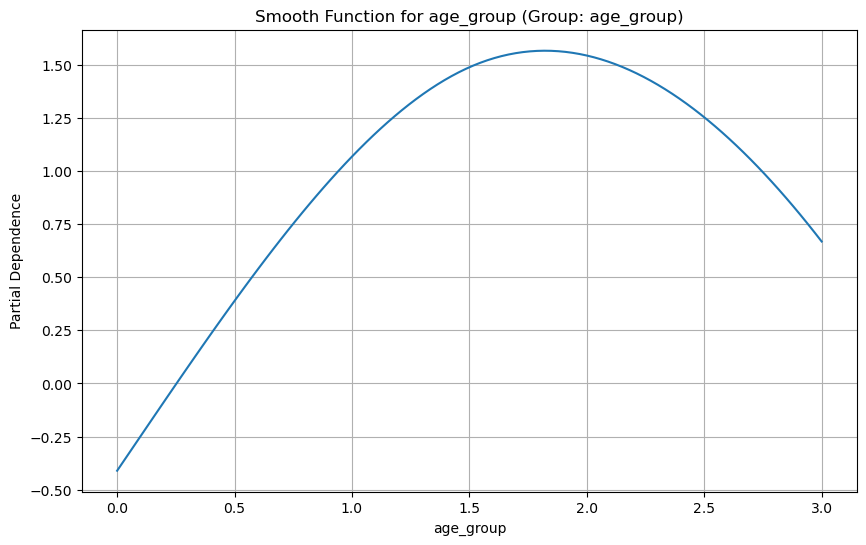

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Training and predicting for group 'credit_score_group'


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:03 ETA:   0:00:01
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


Frequency RMSE for group 'credit_score_group': 4.878298457852018e-05
Severity RMSE for group 'credit_score_group': 18.311449248596055


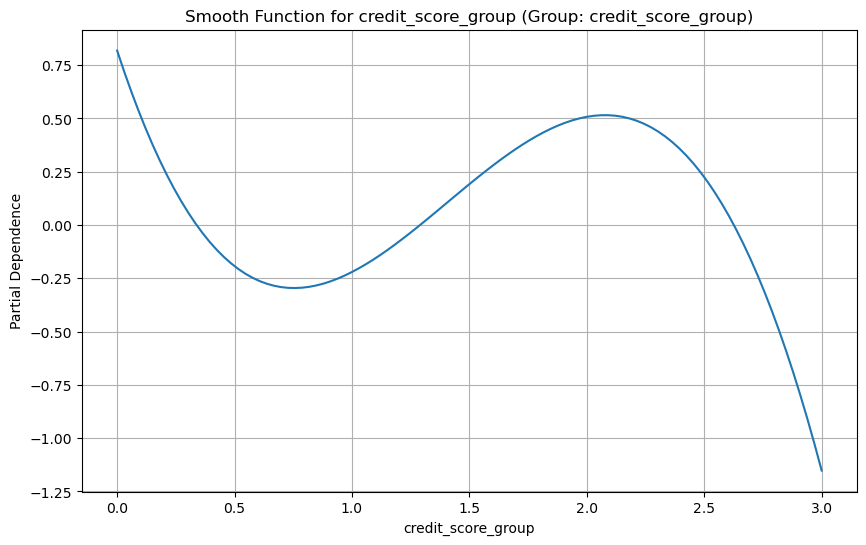

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Training and predicting for group 'annual_miles_group'


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:02 ETA:   0:00:03
 63% (7 of 11) |###############          | Elapsed Time: 0:00:03 ETA:   0:00:04
 72% (8 of 11) |##################       | Elapsed Time: 0:00:07 ETA:   0:00:09
 81% (9 of 11) |####################     | Elapsed Time: 0:00:10 ETA:   0:00:07


did not converge


 90% (10 of 11) |#####################   | Elapsed Time: 0:00:14 ETA:   0:00:03


did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


Frequency RMSE for group 'annual_miles_group': 0.0005803326278085945
Severity RMSE for group 'annual_miles_group': 15.506382262403438


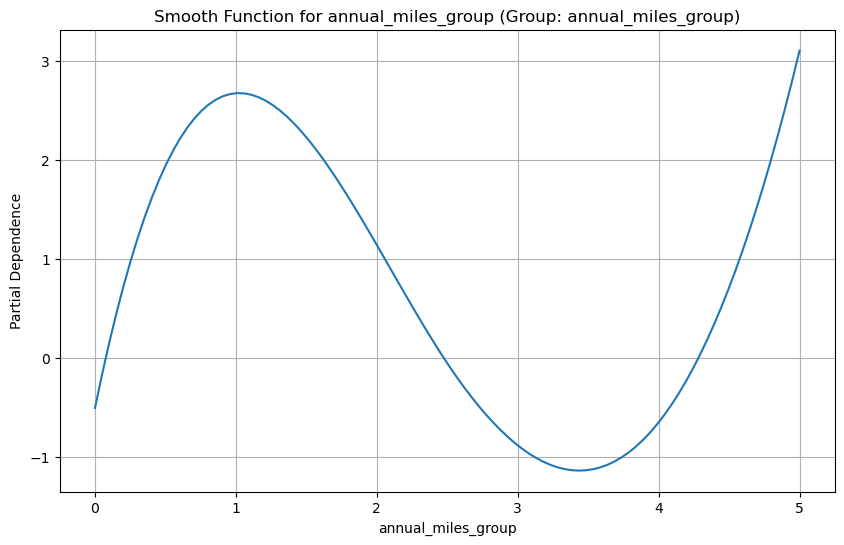

Training and predicting for group 'car_age_group'


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Frequency RMSE for group 'car_age_group': 5.2226596120177585e-05
Severity RMSE for group 'car_age_group': 0.6472593227555119


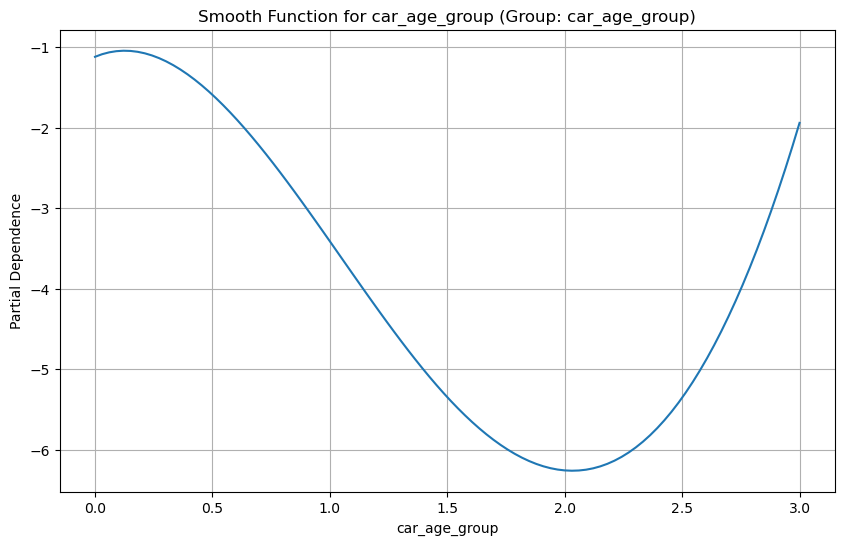

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


Training and predicting for group 'years_noclaims_group'


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Frequency RMSE for group 'years_noclaims_group': 0.0038959590347693173
Severity RMSE for group 'years_noclaims_group': 12.533345967430378


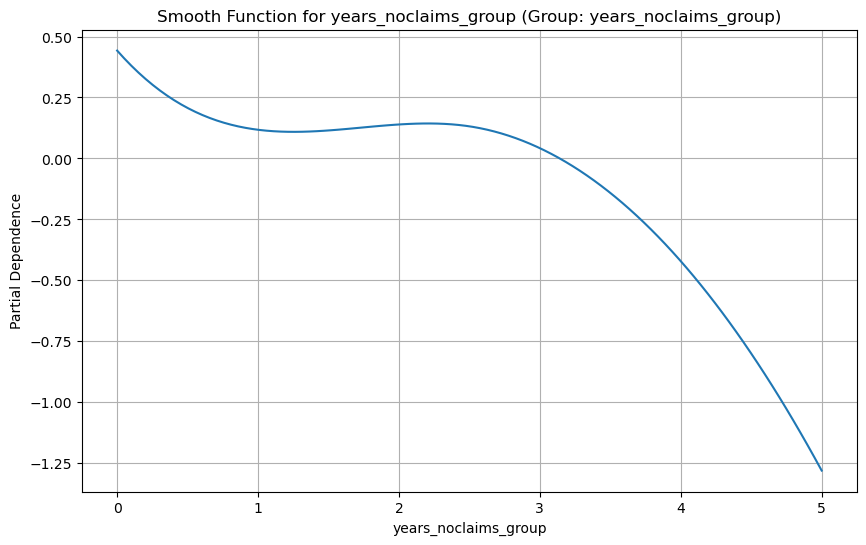

Results saved to 'gam_group_prediction_results.csv'


In [10]:
from pygam import PoissonGAM, LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def train_and_predict_gam_group(df, group_column):
    df_group = df[[group_column, 'NB_Claim', 'AMT_Claim']].dropna().copy()
    df_group[group_column] = LabelEncoder().fit_transform(df_group[group_column])
    
    # Calculate target relative frequency and average severity
    total_claims_in_group = df_group['NB_Claim'].sum()
    df_group['target_relative_frequency'] = df_group.groupby(group_column)['NB_Claim'].transform('sum') / total_claims_in_group
    df_group['target_average_severity'] = df_group.groupby(group_column)['AMT_Claim'].transform('mean')

    # Prepare features and targets for claim frequency
    X = df_group[[group_column]].values
    y_claims = df_group['target_relative_frequency'].values
    gam_freq = PoissonGAM(s(0, n_splines=5, lam=0.6))

    # Perform cross-validation to find the best lambda (regularization parameter)
    lam_range = {'lam': [0.1, 0.3, 0.6, 1.0, 3.0]}
    gam_freq.gridsearch(X, y_claims)
    df_group['predicted_claims'] = gam_freq.predict(X)

    # Calculate RMSE for frequency prediction
    frequency_rmse = np.sqrt(np.mean((df_group['target_relative_frequency'] - df_group['predicted_claims'])**2))
    print(f"Frequency RMSE for group '{group_column}': {frequency_rmse}")

    # Filter the data to include only rows where NB_Claim is not zero for claim severity prediction
    df_non_zero_claims = df_group[df_group['NB_Claim'] > 0].copy()

    if not df_non_zero_claims.empty:
        # Prepare features and targets for claim severity
        X_sev = df_non_zero_claims[[group_column]].values
        y_sev = df_non_zero_claims['target_average_severity'].values

        # Fit a LinearGAM model for claim severity
        gam_sev = LinearGAM(s(0, n_splines=5, lam=0.6)).fit(X_sev, y_sev)
        df_non_zero_claims['predicted_severity'] = gam_sev.predict(X_sev)
        
        # Calculate RMSE for severity prediction
        severity_rmse = np.sqrt(np.mean((df_non_zero_claims['target_average_severity'] - df_non_zero_claims['predicted_severity'])**2))
        print(f"Severity RMSE for group '{group_column}': {severity_rmse}")
    else:
        df_non_zero_claims['predicted_severity'] = None
        severity_rmse = None
        print(f"No severity RMSE for group '{group_column}' as there are no non-zero claims.")

    # Combine the results for frequency and severity
    results = df_group.groupby(group_column).agg(
        actual_frequency=('target_relative_frequency', 'mean'),
        predicted_frequency=('predicted_claims', 'mean')
    ).reset_index()

    if not df_non_zero_claims.empty:
        severity_results = df_non_zero_claims.groupby(group_column).agg(
            actual_severity=('target_average_severity', 'mean'),
            predicted_severity=('predicted_severity', 'mean')
        ).reset_index()
        results = pd.merge(results, severity_results, on=group_column, how='left')

    # Save the results to a CSV file
    results['model'] = 'gam'
    results['group'] = group_column
    results = results[['model', 'group', group_column, 'actual_frequency', 'predicted_frequency', 'actual_severity', 'predicted_severity']]
    results.rename(columns={group_column: 'level'}, inplace=True)

    return results, gam_freq


def plot_gam_smooth_function(gam, group_column, group_name):
    XX = gam.generate_X_grid(term=0)
    plt.figure(figsize=(10, 6))
    plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
    plt.title(f"Smooth Function for {group_name} (Group: {group_column})")
    plt.xlabel(group_column)
    plt.ylabel("Partial Dependence")
    plt.grid(True)
    plt.show()

# Load the prepared dataset from CSV
df = pd.read_csv('final_prepared_data.csv')

# Define the groups of interest
groups_of_interest = ['age_group', 'credit_score_group', 'annual_miles_group', 'car_age_group', 'years_noclaims_group']

# Apply the training and prediction for each group
results_list = []
for group in groups_of_interest:
    print(f"Training and predicting for group '{group}'")
    results, gam_model = train_and_predict_gam_group(df, group)
    results_list.append(results)

    # Plot the smooth function for each group
    plot_gam_smooth_function(gam_model, group, group)

# Combine results and save to a CSV file
final_results = pd.concat(results_list, axis=0)
final_results.to_csv('gam_group_prediction_results.csv', index=False)
print("Results saved to 'gam_group_prediction_results.csv'")
